In [1]:
import numpy as np
from packaging import version
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import binom
from scipy.stats import expon
from scipy.stats import geom
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_array, check_is_fitted
import pandas as pd

In [2]:
import sys

assert sys.version_info >= (3, 7)

In [3]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# MNIST

In [6]:
from sklearn.datasets import fetch_openml

# 사이킷런 1.2에서 추가된 parser 매개변수 기본값이 1.4 버전에서 'liac-arff'에서 'auto'로 바뀝니다.
# 'auto'일 경우 희소한 ARFF 포맷일 때는 'liac-arff', 그렇지 않을 때는 'pandas'가 됩니다.
# 이에 대한 경고를 피하려면 parser='auto'로 지정하세요.
# mnist = fetch_openml('mnist_784', as_frame=False)

In [7]:
# 추가 코드 - 조금 내용이 깁니다
# print(mnist.DESCR)

In [8]:
# import numpy as np
# import gzip
# import os

# def load_mnist_images(filename):
#     with gzip.open(filename, 'rb') as f:
#         _ = int.from_bytes(f.read(4), 'big')  # magic number
#         num_images = int.from_bytes(f.read(4), 'big')
#         rows = int.from_bytes(f.read(4), 'big')
#         cols = int.from_bytes(f.read(4), 'big')
#         images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows * cols)
#         return images

# def load_mnist_labels(filename):
#     with gzip.open(filename, 'rb') as f:
#         _ = int.from_bytes(f.read(4), 'big')  # magic number
#         num_labels = int.from_bytes(f.read(4), 'big')
#         labels = np.frombuffer(f.read(), dtype=np.uint8)
#         return labels

# # 다운로드 받은 파일 경로
# path = 'C:/Users/CJ/사이킥런/datasets/mnist'

# X_train = load_mnist_images(os.path.join(path, 'train-images-idx3-ubyte.gz'))
# y_train = load_mnist_labels(os.path.join(path, 'train-labels-idx1-ubyte.gz'))
# X_test = load_mnist_images(os.path.join(path, 't10k-images-idx3-ubyte.gz'))
# y_test = load_mnist_labels(os.path.join(path, 't10k-labels-idx1-ubyte.gz'))

# print(f"Training set shape: {X_train.shape}, Labels: {y_train.shape}")
# print(f"Test set shape: {X_test.shape}, Labels: {y_test.shape}")

In [9]:
from scipy.io import arff
import pandas as pd

# ARFF 파일 로딩
data, meta = arff.loadarff('C:/Users/CJ/사이킥런/datasets/mnist/mnist_784.arff')
df = pd.DataFrame(data)

# target 열 (레이블) 추출 - 마지막 열이라고 가정
target_col = df.columns[-1]

# byte 형식을 문자열로 디코딩
df[target_col] = df[target_col].apply(lambda x: x.decode('utf-8'))

# 딕셔너리 형태로 구성 (fetch_openml 흉내)
mnist = {
    'data': df.drop(columns=target_col).values,      # X
    'target': df[target_col].values,                 # y
    'frame': df,                                     # 전체 DataFrame
    'feature_names': df.columns[:-1].tolist(),       # 특성 이름
    'target_names': sorted(df[target_col].unique()), # 타겟 클래스들
    'DESCR': 'MNIST handwritten digits dataset loaded from ARFF file.',
    'details': {'source': 'local .arff file'},
    'url': 'https://www.openml.org/d/554'
}

# 확인
print(mnist.keys())


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


In [10]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [11]:
from sklearn.utils import Bunch

mnist = Bunch(
    data=df.drop(columns=target_col).values,
    target=df[target_col].values,
    frame=df,
    feature_names=df.columns[:-1].tolist(),
    target_names=sorted(df[target_col].unique()),
    DESCR='MNIST handwritten digits dataset loaded from ARFF file.',
    details={'source': 'local .arff file'},
    url='https://www.openml.org/d/554'
)

# 이제 아래처럼 사용 가능
X, y = mnist.data, mnist.target

In [12]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
X.shape

(70000, 784)

In [14]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [15]:
y.shape

(70000,)

In [16]:
28 * 28

784

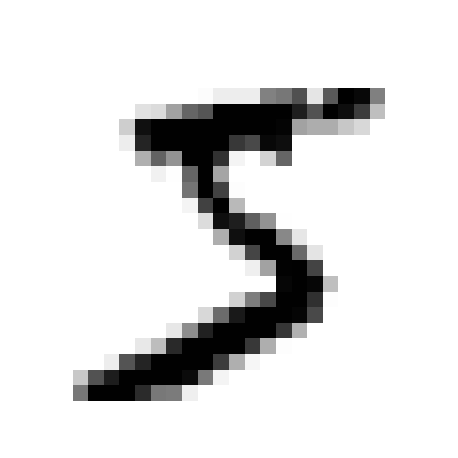

In [17]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # 추가 코드
plt.show()

In [18]:
y[0]

'5'

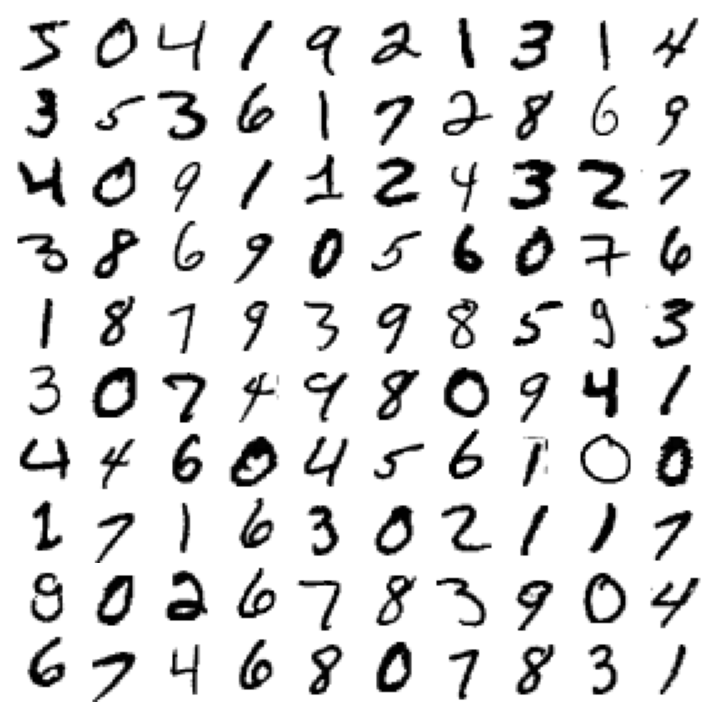

In [19]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 이진 분류기 훈련

In [21]:
y_train_5 = (y_train == '5')  # 5는 True고, 다른 숫자는 모두 False
y_test_5 = (y_test == '5')

In [22]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict([some_digit])

array([ True])

## 성능측정

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [25]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # 데이터셋이 미리 섞여 있지 않다면
                                       # shuffle=True를 추가하세요.
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [26]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [27]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

## 오차 행렬

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [30]:
y_train_perfect_predictions = y_train_5  # 완벽한 분류기일 경우
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 정밀도와 재현율

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

0.8370879772350012

In [32]:
# 추가 코드 – TP / (FP + TP) 식으로 정밀도를 계산합니다
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [33]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

0.6511713705958311

In [34]:
# 추가 코드 – TP / (FN + TP) 식으로 정밀도를 계산합니다
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [35]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [36]:
# 추가 코드 – f1 점수를 계산합니다
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

0.7325171197343847

# 정밀도/재현율 트레이드오프

In [37]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [38]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [39]:
y_some_digit_pred

array([ True])

In [40]:
# 추가 코드 – y_scores > 0이면 predict()를 호출하는 것과 같은 결과를 냅니다
y_scores > 0

array([ True])

In [41]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [42]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [43]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [44]:
thresholds, precisions,thresholds

(array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]),
 array([0.09035   , 0.09035151, 0.09035301, ..., 1.        , 1.        ,
        1.        ]),
 array([-146348.56726174, -142300.00705404, -137588.97581744, ...,
          38871.26391927,   42216.05562787,   49441.43765905]))

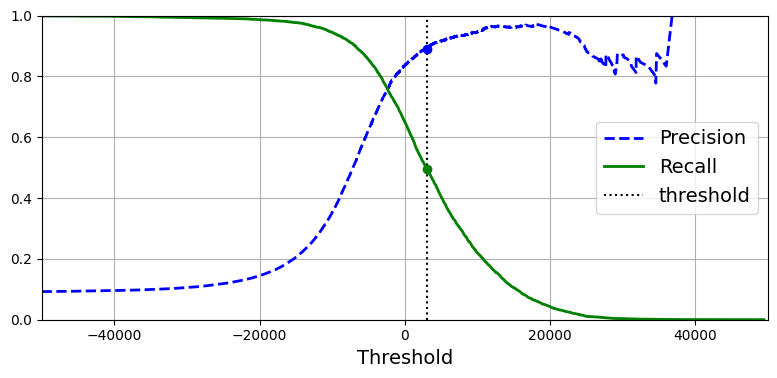

In [45]:
plt.figure(figsize=(8, 4))  # 추가 코드
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# 추가 코드 – 그림 3–5를 그리고 저장합니다
idx = (thresholds >= threshold).argmax()  # 첫 번째 index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
save_fig("precision_recall_vs_threshold_plot")

plt.show()

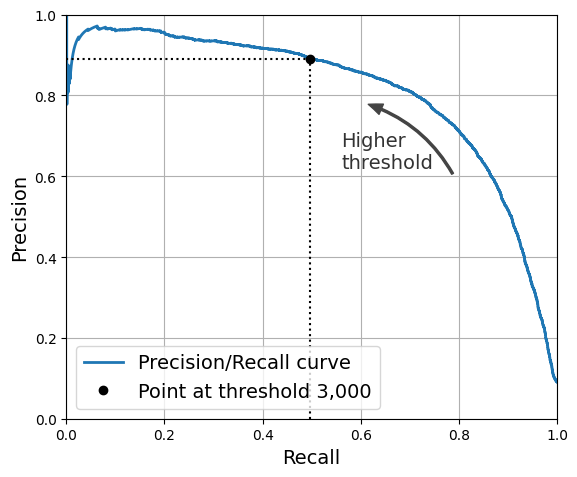

In [46]:
import matplotlib.patches as patches  # 추가 코드 – 구부러진 화살표를 그리기 위해서

plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("precision_vs_recall_plot")

plt.show()

In [47]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439557

In [48]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [49]:
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [50]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [51]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## ROC 곡선



In [52]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

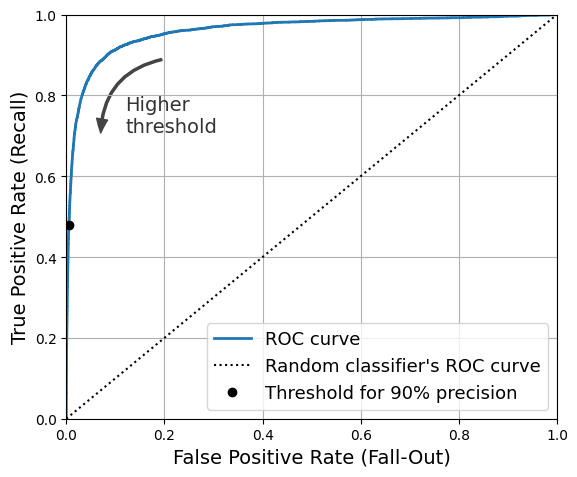

In [53]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # 추가 코드
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# 추가 코드 – 그림 3–7을 그리고 저장합니다
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)
save_fig("roc_curve_plot")

plt.show()

In [54]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [55]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [56]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [57]:
num_samples = y_probas_forest.shape[0]
print(f"총 샘플 개수: {num_samples}")

num_samples = y_probas_forest.shape[1]
print(f"총 샘플 열수: {num_samples}")

y_probas_forest

총 샘플 개수: 60000
총 샘플 열수: 2


array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [58]:
# 책에는 없음
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
idx_50_to_60
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

94.0%


In [59]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

In [60]:
y_probas_forest[:, 1]

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

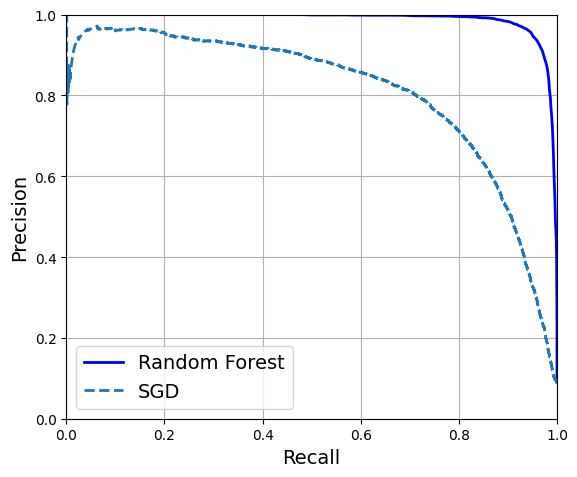

In [61]:
plt.figure(figsize=(6, 5))  # 추가 코드

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# 추가 코드 – 그림 3–8을 그리고 저장합니다
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
save_fig("pr_curve_comparison_plot")

plt.show()

In [62]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # 양성 확률 ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [63]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [64]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [65]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## 다중 분류

In [66]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train_5가 아니고 y_train을 사용합니다.

SVC(random_state=42)

In [67]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [68]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [69]:
class_id = some_digit_scores.argmax()
class_id

5

In [70]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [71]:
svm_clf.classes_[class_id]

'5'

In [72]:
# 추가 코드 – 45개 OvO 점수를 얻는 방법
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [73]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [74]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [75]:
len(ovr_clf.estimators_)

10

In [76]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [77]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 에러분석

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # 추가 코드 - 폰트 크기를 줄입니다
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

In [ ]:
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10)  # 추가 코드
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

In [ ]:
# 추가 코드 – 그림 3–9을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")
save_fig("confusion_matrix_plot_1")
plt.show()

In [ ]:
# 추가 코드 – 그림 3–10을 생성하고 저장합니다
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
save_fig("confusion_matrix_plot_2")
plt.show()
plt.rc('font', size=14)  # 폰트 크기를 다시 키웁니다

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
# 추가 코드 – 그림 3–11을 생성하고 저장합니다
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
save_fig("error_analysis_digits_plot")
plt.show()

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

In [ ]:
knn_clf.predict([some_digit])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# 추가 코드 – average="weighted"로 지정했을 때 성능 향상은 무시할 수 있는 수준입니다.
#           이 클래스는 이미 꽤 균형 잡혀 있기 때문입니다.
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [ ]:
chain_clf.predict([some_digit])

## 다중 출력 분류

In [ ]:
np.random.seed(42)  # 동일하게 재현되게 하려고 지정합니다
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
# 추가 코드 – 그림 3–12을 생성하고 저장합니다
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])
save_fig("noisy_digit_example_plot")
plt.show()

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
save_fig("cleaned_digit_example_plot")  # 추가 코드 – 그림 3–13을 저장합니다
plt.show()

## 연습문제

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
baseline_accuracy = knn_clf.score(X_test, y_test)
baseline_accuracy



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from itertools import product
import joblib
import os

# 파라미터 후보 정의
param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# 조합 만들기
param_combinations = list(product(
    param_grid['n_neighbors'],
    param_grid['weights'],
    param_grid['p']
))

results = []
results_file = "knn_gridsearch_results.pkl"

# 이전 결과 있으면 불러오기 (중간 이어서)
if os.path.exists(results_file):
    results = joblib.load(results_file)
    done_params = [r['params'] for r in results]
else:
    done_params = []

# 반복하면서 학습 및 저장
for n_neighbors, weights, p in param_combinations:
    params = {'n_neighbors': n_neighbors, 'weights': weights, 'p': p}
    
    # 이미 학습된 조합이면 스킵
    if params in done_params:
        print("이미 완료됨:", params)
        continue

    # 모델 학습
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    scores = cross_val_score(knn, X_train, y_train, cv=3, scoring='accuracy')
    mean_score = scores.mean()

    result = {
        'params': params,
        'score': mean_score
    }
    results.append(result)
    print("진행:", params, "→ 평균 정확도:", mean_score)

    # 중간 저장
    joblib.dump(results, results_file)

# 최적 파라미터 출력
best_result = max(results, key=lambda x: x['score'])
print("최적 파라미터:", best_result['params'])
print("최고 정확도:", best_result['score'])


## 문제2 여기서 진행해

In [1]:
import numpy as np
from packaging import version
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import binom
from scipy.stats import expon
from scipy.stats import geom
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_array, check_is_fitted
import pandas as pd

In [2]:
from sklearn.datasets import fetch_openml

In [3]:
from scipy.io import arff
import pandas as pd

original_path = r'C:\Users\CJ\사이킥런\datasets\mnist'
converted_path = original_path.replace('\\', '/')

# Construct the full ARFF file path
arff_file_path = f'{converted_path}/mnist_784.arff'
# ARFF 파일 로딩
data, meta = arff.loadarff(arff_file_path)
df = pd.DataFrame(data)

# target 열 (레이블) 추출 - 마지막 열이라고 가정
target_col = df.columns[-1]

# byte 형식을 문자열로 디코딩
df[target_col] = df[target_col].apply(lambda x: x.decode('utf-8'))

# 딕셔너리 형태로 구성 (fetch_openml 흉내)
mnist = {
    'data': df.drop(columns=target_col).values,      # X
    'target': df[target_col].values,                 # y
    'frame': df,                                     # 전체 DataFrame
    'feature_names': df.columns[:-1].tolist(),       # 특성 이름
    'target_names': sorted(df[target_col].unique()), # 타겟 클래스들
    'DESCR': 'MNIST handwritten digits dataset loaded from ARFF file.',
    'details': {'source': 'local .arff file'},
    'url': 'https://www.openml.org/d/554'
}

# 확인
print(mnist.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/CJ/사이킥런/datasets/mnist/mnist_784.arff'

In [21]:
from sklearn.utils import Bunch

mnist = Bunch(
    data=df.drop(columns=target_col).values,
    target=df[target_col].values,
    frame=df,
    feature_names=df.columns[:-1].tolist(),
    target_names=sorted(df[target_col].unique()),
    DESCR='MNIST handwritten digits dataset loaded from ARFF file.',
    details={'source': 'local .arff file'},
    url='https://www.openml.org/d/554'
)

# 이제 아래처럼 사용 가능
X, y = mnist.data, mnist.target

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [25]:
# len() 함수를 사용하여 각 배열의 길이를 측정합니다.

print(f"X_train 길이: {len(X_train)}")
print(f"y_train 길이: {len(y_train)}")
print(f"X_test 길이: {len(X_test)}")
print(f"y_test 길이: {len(y_test)}")

X_train 길이: 60000
y_train 길이: 60000
X_test 길이: 10000
y_test 길이: 10000


In [26]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

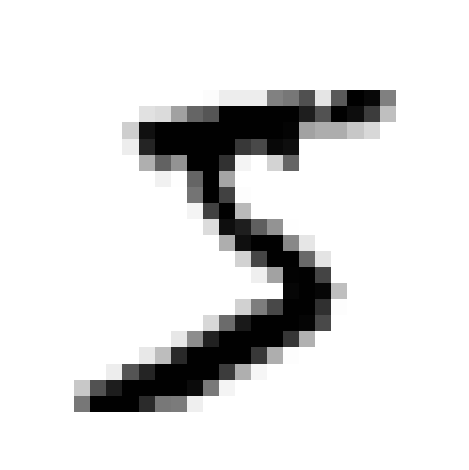

In [27]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
save_fig("some_digit_plot")  # 추가 코드
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Assuming X and y are already loaded from your previous code
# X, y = mnist.data, mnist.target

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def plot_digit(image_data, title=""):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if title:
        plt.title(title)

some_digit = X[0] # The first digit from your loaded dataset

In [29]:
import matplotlib as mpl
print(mpl.get_cachedir())

C:\Users\CJ\.matplotlib


In [30]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # 폰트 매니저 모듈 임포트

# ----------------------------------------------------
# Matplotlib 한글 폰트 설정 시작
# ----------------------------------------------------
# 폰트 경로 설정 (Windows의 경우)
# 'Malgun Gothic'이 설치되어 있는지 확인하고 사용하세요.
# 다른 폰트를 사용하고 싶다면 폰트 파일명(예: 'NanumGothic.ttf')이나 폰트 이름으로 변경.
font_path = 'C:/Windows/Fonts/malgun.ttf' # 맑은 고딕 폰트 경로 예시

# 폰트 속성 설정
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
# ----------------------------------------------------
# Matplotlib 한글 폰트 설정 끝
# ----------------------------------------------------

# (나머지 코드...)
# from scipy.io import arff
# import pandas as pd

총 70000개의 이미지에 대해 이동을 적용합니다...
X_shifted_up 길이: 60000
X_shifted_down 길이: 60000
X_shifted_left 길이: 60000
X_shifted_right 길이: 60000
모든 이미지의 이동이 완료되었습니다.
위로 이동된 데이터셋 형태: (60000, 784)

첫 번째 이미지와 그 이동된 버전을 시각화합니다.


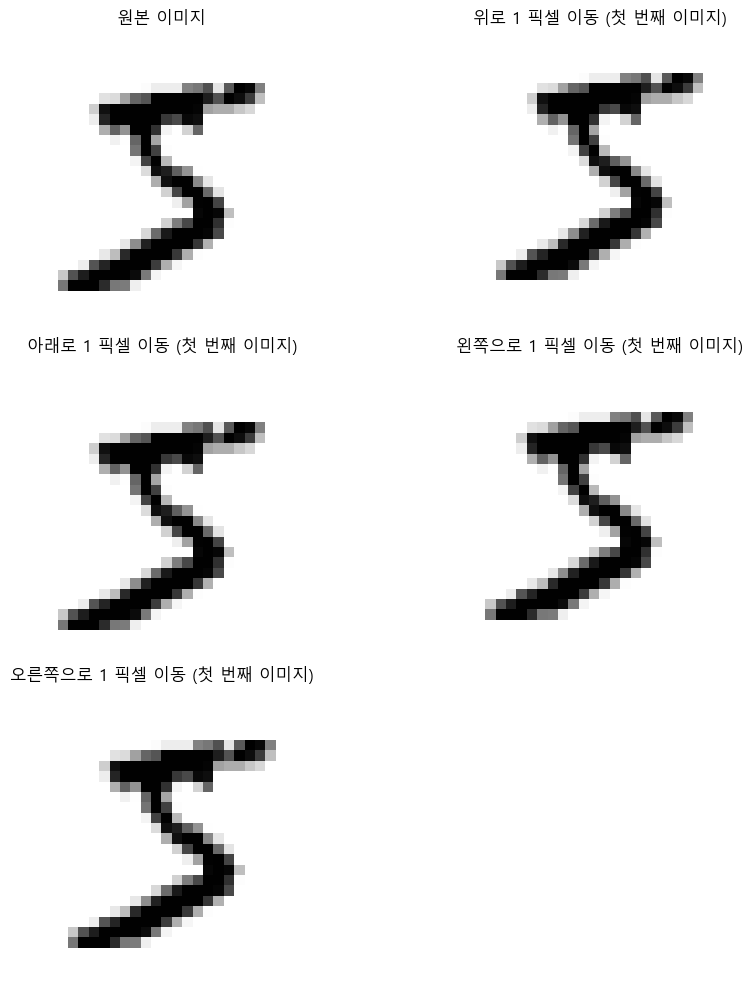

In [31]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.utils import Bunch


# --- 3. 이미지 이동 함수 (기존과 동일) ---
def shift_image(image_data, direction, pixels):
    """
    28x28 이미지를 지정된 방향으로 이동시킵니다.

    인자:
        image_data (np.array): 784 픽셀 값의 1D 넘파이 배열.
        direction (str): 'up', 'down', 'left', 또는 'right'.
        pixels (int): 이동시킬 픽셀 수.

    반환:
        np.array: 이동된 이미지를 나타내는 784 픽셀 값의 새로운 1D 넘파이 배열.
    """
    image = image_data.reshape(28, 28)
    shifted_image = np.copy(image) # 원본을 수정하지 않도록 복사본을 생성합니다.

    if direction == 'up':
        shifted_image = np.roll(shifted_image, -pixels, axis=0)
        # np.roll은 순환 이동이므로, 비어있는 부분을 0으로 채워야 합니다.
        # 위로 이동했으니 아래쪽 'pixels' 수만큼의 행이 비게 됩니다.
        shifted_image[28 - pixels:] = 0
    elif direction == 'down':
        shifted_image = np.roll(shifted_image, pixels, axis=0)
        # 아래로 이동했으니 위쪽 'pixels' 수만큼의 행이 비게 됩니다.
        shifted_image[:pixels] = 0
    elif direction == 'left':
        shifted_image = np.roll(shifted_image, -pixels, axis=1)
        # 왼쪽으로 이동했으니 오른쪽 'pixels' 수만큼의 열이 비게 됩니다.
        shifted_image[:, 28 - pixels:] = 0
    elif direction == 'right':
        shifted_image = np.roll(shifted_image, pixels, axis=1)
        # 오른쪽으로 이동했으니 왼쪽 'pixels' 수만큼의 열이 비게 됩니다.
        shifted_image[:, :pixels] = 0
    else:
        raise ValueError("Direction must be 'up', 'down', 'left', or 'right'.")

    return shifted_image.flatten()

# --- 4. 모든 이미지에 이동 적용 및 새로운 데이터셋 생성 ---

# 이동량 정의
shift_amount = 1 # 예를 들어 1 픽셀 이동

# 이동된 이미지를 저장할 리스트들
X_shifted_up = []
X_shifted_down = []
X_shifted_left = []
X_shifted_right = []

# 원본 이미지의 레이블을 저장할 리스트 (나중에 사용될 수 있음)
y_original = y.copy()

# 모든 이미지에 대해 이동을 적용
print(f"총 {len(X)}개의 이미지에 대해 이동을 적용합니다...")
for i, image_data in enumerate(X_train):
    X_shifted_up.append(shift_image(image_data, 'up', shift_amount))
    X_shifted_down.append(shift_image(image_data, 'down', shift_amount))
    X_shifted_left.append(shift_image(image_data, 'left', shift_amount))
    X_shifted_right.append(shift_image(image_data, 'right', shift_amount))

# 리스트들을 NumPy 배열로 변환
X_shifted_up = np.array(X_shifted_up)
X_shifted_down = np.array(X_shifted_down)
X_shifted_left = np.array(X_shifted_left)
X_shifted_right = np.array(X_shifted_right)

# len() 함수를 사용하여 각 배열의 길이를 측정합니다.

print(f"X_shifted_up 길이: {len(X_shifted_up)}")
print(f"X_shifted_down 길이: {len(X_shifted_down)}")
print(f"X_shifted_left 길이: {len(X_shifted_left)}")
print(f"X_shifted_right 길이: {len(X_shifted_right)}")


print("모든 이미지의 이동이 완료되었습니다.")
print(f"위로 이동된 데이터셋 형태: {X_shifted_up.shape}")
X
# --- 5. 선택 사항: 증강된 데이터셋 합치기 ---
# 원본 데이터와 이동된 데이터를 모두 포함하는 새로운 데이터셋을 만들 수 있습니다.
# 예를 들어, 분류 모델 훈련을 위해 데이터를 확장하는 경우에 유용합니다.

# --- 6. (선택 사항) 결과 확인을 위해 첫 번째 이미지와 이동된 버전 시각화 ---
print("\n첫 번째 이미지와 그 이동된 버전을 시각화합니다.")
plt.figure(figsize=(10, 10))

# 원본 이미지
plt.subplot(3, 2, 1)
plot_digit(X[0], title="원본 이미지")

# 이동된 이미지들 (첫 번째 이미지에 대한 결과)
plt.subplot(3, 2, 2)
plot_digit(X_shifted_up[0], title=f"위로 {shift_amount} 픽셀 이동 (첫 번째 이미지)")

plt.subplot(3, 2, 3)
plot_digit(X_shifted_down[0], title=f"아래로 {shift_amount} 픽셀 이동 (첫 번째 이미지)")

plt.subplot(3, 2, 4)
plot_digit(X_shifted_left[0], title=f"왼쪽으로 {shift_amount} 픽셀 이동 (첫 번째 이미지)")

plt.subplot(3, 2, 5)
plot_digit(X_shifted_right[0], title=f"오른쪽으로 {shift_amount} 픽셀 이동 (첫 번째 이미지)")

plt.tight_layout()
save_fig("all_shifted_digits_example_ko") # 저장 파일명 변경
plt.show()

In [33]:
X_augmented = np.vstack([X_train, X_shifted_up, X_shifted_down, X_shifted_left, X_shifted_right])
y_augmented = np.concatenate([y_train, y_train, y_train, y_train, y_train])

print(f"\n원본 + 이동된 데이터셋 (X_augmented) 형태: {X_augmented.shape}")
print(f"원본 + 이동된 레이블 (y_augmented) 형태: {y_augmented.shape}")


원본 + 이동된 데이터셋 (X_augmented) 형태: (300000, 784)
원본 + 이동된 레이블 (y_augmented) 형태: (300000,)


In [34]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


# 2. 데이터 셔플링
shuffle_idx = np.random.permutation(len(X_augmented))
X_train_augmented = X_augmented[shuffle_idx]
y_train_augmented = y_augmented[shuffle_idx]

# 3. KNN 분류기 정의 및 훈련
best_params = {'n_neighbors': 4, 'weights': 'distance'}
knn_clf = KNeighborsClassifier(**best_params)

# 4. 모델 학습
knn_clf.fit(X_train_augmented, y_train_augmented)

# 학습 완료 후 모델은 knn_clf 변수에 저장됨


KNeighborsClassifier(n_neighbors=4, weights='distance')

In [35]:
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

## 아래건 너무 오래걸림하지마

In [ ]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import cross_val_score
# from itertools import product
# import joblib
# import os

# # 파라미터 후보 정의
# param_grid = {
#     'n_neighbors': [1, 2, 3, 4, 5, 6, 7],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]
# }

# # 조합 만들기
# param_combinations = list(product(
#     param_grid['n_neighbors'],
#     param_grid['weights'],
#     param_grid['p']
# ))

# results = []
# results_file = "knn_gridsearch_X_concat_results.pkl"

# # 이전 결과 있으면 불러오기 (중간 이어서)
# if os.path.exists(results_file):
#     results = joblib.load(results_file)
#     done_params = [r['params'] for r in results]
# else:
#     done_params = []

# # 반복하면서 학습 및 저장
# for n_neighbors, weights, p in param_combinations:
#     params = {'n_neighbors': n_neighbors, 'weights': weights, 'p': p}
    
#     # 이미 학습된 조합이면 스킵
#     if params in done_params:
#         print("이미 완료됨:", params)
#         continue

#     # 모델 학습
#     knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
#     scores = cross_val_score(knn, X_augmented, y_augmented, cv=3, scoring='accuracy')
#     mean_score = scores.mean()

#     result = {
#         'params': params,
#         'score': mean_score
#     }
#     results.append(result)
#     print("진행:", params, "→ 평균 정확도:", mean_score)

#     # 중간 저장
#     joblib.dump(results, results_file)

# # 최적 파라미터 출력
# best_result = max(results, key=lambda x: x['score'])
# print("최적 파라미터:", best_result['params'])
# print("최고 정확도:", best_result['score'])


## 타이타닉 데이터셋 도전하기

In [1]:
import numpy as np
from packaging import version
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import binom
from scipy.stats import expon
from scipy.stats import geom
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_array, check_is_fitted
import pandas as pd

In [5]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_titanic_data():
    tarball_path = Path("datasets/titanic.tgz")
    # if not tarball_path.is_file():
    #     Path("datasets").mkdir(parents=True, exist_ok=True)
    #     url = "https://github.com/ageron/data/raw/main/titanic.tgz"
    #     urllib.request.urlretrieve(url, tarball_path)
    #     with tarfile.open(tarball_path) as titanic_tarball:
    #         titanic_tarball.extractall(path="datasets")
    return [pd.read_csv(Path("C:/Users/CJ/사이킥런/datasets/titanic") / filename)
            for filename in ("train.csv", "test.csv")]

In [32]:
train_data, test_data = load_titanic_data()

In [33]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [39]:
# train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
# train_data['Age'].fillna(train_data['Age'].median(), inplace=True)
# train_data['Embarked'].fillna('S', inplace=True)
# train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})
# test_data['Age'].fillna(test_data['Age'].median(), inplace=True)
# test_data['Embarked'].fillna('S', inplace=True)
# test_data['Embarked'] = test_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']


# X_train_data = train_data[features]
# y_train_data = train_data['Survived']

# X_test_data = test_data[features]
# # y_test_data = test_data['Survived']



In [43]:
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [44]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [45]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [38]:
import pandas as pd
import numpy as np
from pathlib import Path

# Scikit-learn 라이브러리 임포트
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


# 훈련 데이터에서 레이블(Survived) 분리
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"].copy()
X_test = test_data.copy() # 테스트 데이터는 그대로 사용

# 2. 전처리 파이프라인 구축
# 수치형 데이터 파이프라인: 결측치(NaN)를 중간값으로 채우고, 데이터의 스케일을 조정합니다.
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Age, Fare 등의 결측치 처리
    ('scaler', StandardScaler()),
])

# 범주형 데이터 파이프라인: 결측치를 최빈값으로 채우고, 원-핫 인코딩을 적용합니다.
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")), # Embarked 등의 결측치 처리
    ('onehot', OneHotEncoder(handle_unknown='ignore')),    # Sex, Embarked를 0/1로 변환
])

# 3. 데이터 타입에 따라 파이프라인 적용할 컬럼 지정
# 수치형 특성
num_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']
# 범주형 특성
cat_features = ['Sex', 'Embarked']

# 4. ColumnTransformer로 두 파이프라인 합치기
# 어떤 컬럼에 어떤 파이프라인을 적용할지 정의합니다.
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
])

# 5. 전체 파이프라인을 훈련 데이터에 적용 (학습 및 변환)
X_train_prepared = preprocessor.fit_transform(X_train)

# 6. 훈련된 파이프라인을 테스트 데이터에 적용 (변환만 수행)
X_test_prepared = preprocessor.transform(X_test)

# 결과 확인 (Numpy 배열 형태로 출력됨)
print("전처리된 훈련 데이터 shape:", X_train_prepared.shape)
print("전처리된 테스트 데이터 shape:", X_test_prepared.shape)

전처리된 훈련 데이터 shape: (891, 10)
전처리된 테스트 데이터 shape: (418, 10)


In [47]:
X_train_prepared[0]

array([-0.56573582, -0.50244517,  0.43279337, -0.47367361,  0.82737724,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ])

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split

# 1. 모델 선택 및 훈련
# 여기서는 랜덤 포레스트 분류기를 사용합니다.
# n_estimators는 트리의 개수, random_state는 재현성을 위한 시드 값입니다.
model = RandomForestClassifier(n_estimators=100, random_state=42)

# 모델 훈련
model.fit(X_train_prepared, y_train)

# 2. 훈련된 모델로 예측 수행
# 캐글 제출을 위한 테스트 데이터 예측
test_predictions = model.predict(X_test_prepared)

# --- (선택 사항: 모델 성능 검증을 위한 훈련 데이터 분할) ---
# 보통 실제 성능을 더 정확히 평가하기 위해 훈련 데이터를 다시 훈련/검증 세트로 나눕니다.
# 여기서는 모델을 훈련 데이터 전체에 학습시켰으므로,
# 실제 Kaggle 제출을 위해서는 X_test_prepared에 대한 예측을 바로 사용합니다.
# 하지만 모델의 일반화 성능을 확인하려면 훈련 데이터를 분할하여 교차 검증을 수행하는 것이 좋습니다.

# 예시: 훈련 데이터를 다시 훈련/검증 세트로 분할하여 모델 성능 검증
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_prepared, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 분할된 훈련 세트로 모델 다시 훈련 (선택 사항)
val_model = RandomForestClassifier(n_estimators=100, random_state=42)
val_model.fit(X_train_split, y_train_split)

# 검증 세트로 예측
val_predictions = val_model.predict(X_val_split)

# 3. 모델 성능 평가 (검증 세트를 사용하여)
print("\n--- 검증 세트(Validation Set)를 사용한 모델 성능 평가 ---")
print(f"정확도 (Accuracy): {accuracy_score(y_val_split, val_predictions):.4f}")
print(f"정밀도 (Precision): {precision_score(y_val_split, val_predictions):.4f}")
print(f"재현율 (Recall): {recall_score(y_val_split, val_predictions):.4f}")
print(f"F1-점수 (F1-Score): {f1_score(y_val_split, val_predictions):.4f}")

# 예측 확률을 사용하여 AUC 계산
val_probabilities = val_model.predict_proba(X_val_split)[:, 1] # 1은 '생존' 클래스에 대한 확률
print(f"AUC: {roc_auc_score(y_val_split, val_probabilities):.4f}")

# 교차 검증(Cross-validation)을 통한 성능 평가 (더 견고한 평가)
# 5-fold cross-validation 예시
forest_scores = cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='accuracy')
print(f"\n--- 5-Fold 교차 검증 정확도 ---")
print(f"각 폴드의 정확도: {forest_scores}")
print(f"평균 정확도: {np.mean(forest_scores):.4f} (표준편차: {np.std(forest_scores):.4f})")

# 4. 캐글 제출을 위한 예측 파일 생성 (선택 사항)
# 캐글 대회에서는 보통 특정 형식의 CSV 파일을 요구합니다.
# submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_predictions})
# submission_df.to_csv('submission.csv', index=False)
# print("\n'submission.csv' 파일이 생성되었습니다.")


--- 검증 세트(Validation Set)를 사용한 모델 성능 평가 ---
정확도 (Accuracy): 0.8101
정밀도 (Precision): 0.7869
재현율 (Recall): 0.6957
F1-점수 (F1-Score): 0.7385
AUC: 0.8285

--- 5-Fold 교차 검증 정확도 ---
각 폴드의 정확도: [0.75555556 0.83146067 0.76404494 0.84269663 0.88764045 0.83146067
 0.82022472 0.76404494 0.84269663 0.84269663]
평균 정확도: 0.8183 (표준편차: 0.0409)


In [58]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# 1. 모델 선택 및 훈련
# probability=True: predict_proba 사용을 위해 필요
model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)

# 모델 훈련
model.fit(X_train_prepared, y_train)

# 2. 캐글 제출용 예측
test_predictions = model.predict(X_test_prepared)

# 3. 모델 성능 평가를 위한 데이터 분할
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_prepared, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 검증용 모델 훈련
val_model = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
val_model.fit(X_train_split, y_train_split)

# 예측
val_predictions = val_model.predict(X_val_split)

# 성능 지표 출력
print("\n--- 검증 세트(Validation Set)를 사용한 SVM 모델 성능 평가 ---")
print(f"정확도 (Accuracy): {accuracy_score(y_val_split, val_predictions):.4f}")
print(f"정밀도 (Precision): {precision_score(y_val_split, val_predictions):.4f}")
print(f"재현율 (Recall): {recall_score(y_val_split, val_predictions):.4f}")
print(f"F1-점수 (F1-Score): {f1_score(y_val_split, val_predictions):.4f}")

# AUC 계산
val_probabilities = val_model.predict_proba(X_val_split)[:, 1]
print(f"AUC: {roc_auc_score(y_val_split, val_probabilities):.4f}")

# 4. 교차 검증
svm_scores = cross_val_score(model, X_train_prepared, y_train, cv=10, scoring='accuracy')
print(f"\n--- 5-Fold 교차 검증 정확도 ---")
print(f"각 폴드의 정확도: {svm_scores}")
print(f"평균 정확도: {np.mean(svm_scores):.4f} (표준편차: {np.std(svm_scores):.4f})")

# 5. 캐글 제출용 파일 (선택 사항)
# import pandas as pd
# submission_df = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': test_predictions})
# submission_df.to_csv('submission_svm.csv', index=False)
# print("\n'submission_svm.csv' 파일이 생성되었습니다.")



--- 검증 세트(Validation Set)를 사용한 SVM 모델 성능 평가 ---
정확도 (Accuracy): 0.8156
정밀도 (Precision): 0.8214
재현율 (Recall): 0.6667
F1-점수 (F1-Score): 0.7360
AUC: 0.8411

--- 5-Fold 교차 검증 정확도 ---
각 폴드의 정확도: [0.8        0.85393258 0.76404494 0.87640449 0.83146067 0.78651685
 0.82022472 0.78651685 0.86516854 0.85393258]
평균 정확도: 0.8238 (표준편차: 0.0364)


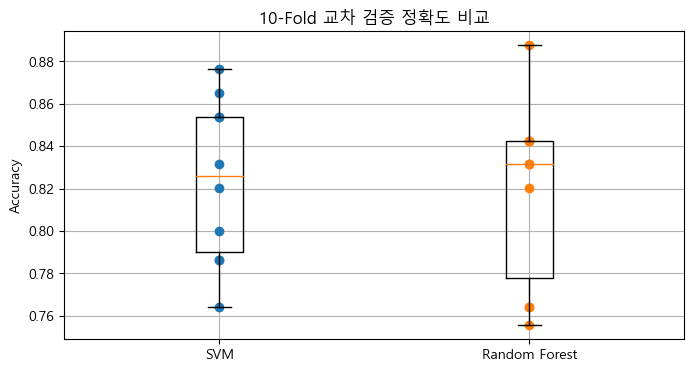

In [63]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# 박스 플롯 시각화
plt.figure(figsize=(8, 4))

# 점 분포
plt.plot([1]*10, svm_scores, "o", label="SVM 점수")      # 점은 원형 표시
plt.plot([2]*10, forest_scores, "o", label="RF 점수")

# 박스 플롯
plt.boxplot([svm_scores, forest_scores], labels=["SVM", "Random Forest"])

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform

# 시스템이 윈도우인지 확인

plt.rc('font', family='Malgun Gothic')  # Windows에서 한글 폰트 설정

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 예시
plt.title("10-Fold 교차 검증 정확도 비교")

plt.ylabel("Accuracy")
plt.title("10-Fold 교차 검증 정확도 비교")
plt.grid(True)
plt.show()


## 4번 스팸 분류

In [1]:
import numpy as np
from packaging import version
from pathlib import Path
from zlib import crc32
from scipy import stats
from scipy.stats import binom
from scipy.stats import expon
from scipy.stats import geom
from scipy.stats import randint
from scipy.stats import uniform
from scipy.stats import loguniform
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_array, check_is_fitted
import pandas as pd

In [2]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

In [3]:
# import tarfile

# C:\Users\CJ\사이킥런\datasets\spam 이거 로컬 경로에 있어서 아래 외부연동해서 가져오는것 주석처리해주고
# 위에 디렉토리 위치로 바꿔줘
# def fetch_spam_data():
#     spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
#     ham_url = spam_root + "20030228_easy_ham.tar.bz2"
#     spam_url = spam_root + "20030228_spam.tar.bz2"

#     spam_path = Path() / "datasets" / "spam"
#     spam_path.mkdir(parents=True, exist_ok=True)
#     for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
#                                     ("spam", "spam", spam_url)):
#         if not (spam_path / dir_name).is_dir():
#             path = (spam_path / tar_name).with_suffix(".tar.bz2")
#             print("Downloading", path)
#             urllib.request.urlretrieve(url, path)
#             tar_bz2_file = tarfile.open(path)
#             tar_bz2_file.extractall(path=spam_path)
#             tar_bz2_file.close()
#     return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

In [4]:
from pathlib import Path
def fetch_spam_data():
    # 외부 다운로드 관련 코드 주석 처리
    # spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    # ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    # spam_url = spam_root + "20030228_spam.tar.bz2"

    # 로컬에 있는 데이터셋 경로로 직접 지정
    spam_path = Path(r"C:/Users/CJ/사이킥런/datasets/spam")

    # 만약 존재하지 않으면 에러를 내는 것도 가능
    if not spam_path.exists():
        raise FileNotFoundError(f"{spam_path} 디렉토리가 존재하지 않습니다.")

    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]


In [5]:
ham_dir, spam_dir = fetch_spam_data()

In [6]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]

In [7]:
len(ham_filenames)

2500

In [8]:
len(spam_filenames)

500

In [9]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [10]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

In [11]:
print(ham_emails[1].get_content().strip())

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [12]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


In [13]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

In [14]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [15]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [16]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [17]:
# 햄(정상) 이메일에는 0, 스팸 이메일에는 1 레이블 부여
# X는 이메일 객체 리스트, y는 해당 레이블 리스트입니다.
X = np.array(ham_emails + spam_emails, dtype=object) # 이메일 객체를 NumPy 배열로 변환
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails)) # 해당 레이블 배열 생성

print(f"\n전체 데이터셋 X (이메일 객체) 크기: {X.shape}")
print(f"전체 레이블 y 크기: {y.shape}")

# scikit-learn의 train_test_split을 사용하여 데이터 분할
# test_size=0.2 는 전체 데이터 중 20%를 테스트 세트로 사용 (나머지 80%는 훈련 세트)
# random_state=42는 재현 가능한 결과를 위해 설정합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\n훈련 데이터 크기 (X_train): {X_train.shape}")
print(f"훈련 레이블 크기 (y_train): {y_train.shape}")
print(f"테스트 데이터 크기 (X_test): {X_test.shape}")
print(f"테스트 레이블 크기 (y_test): {y_test.shape}")


전체 데이터셋 X (이메일 객체) 크기: (3000,)
전체 레이블 y 크기: (3000,)

훈련 데이터 크기 (X_train): (2400,)
훈련 레이블 크기 (y_train): (2400,)
테스트 데이터 크기 (X_test): (600,)
테스트 레이블 크기 (y_test): (600,)


In [19]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

In [20]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE></TITLE><META http-equiv="Content-Type" content="text/html; charset=windows-1252"><STYLE>A:link {TEX-DECORATION: none}A:active {TEXT-DECORATION: none}A:visited {TEXT-DECORATION: none}A:hover {COLOR: #0033ff; TEXT-DECORATION: underline}</STYLE><META content="MSHTML 6.00.2713.1100" name="GENERATOR"></HEAD>
<BODY text="#000000" vLink="#0033ff" link="#0033ff" bgColor="#CCCC99"><TABLE borderColor="#660000" cellSpacing="0" cellPadding="0" border="0" width="100%"><TR><TD bgColor="#CCCC99" valign="top" colspan="2" height="27">
<font size="6" face="Arial, Helvetica, sans-serif" color="#660000">
<b>OTC</b></font></TD></TR><TR><TD height="2" bgcolor="#6a694f">
<font size="5" face="Times New Roman, Times, serif" color="#FFFFFF">
<b>&nbsp;Newsletter</b></font></TD><TD height="2" bgcolor="#6a694f"><div align="right"><font color="#FFFFFF">
<b>Discover Tomorrow's Winners&nbsp;</b></font></div></TD></TR><TR><TD height="25" colspan="2" bgcolor="#CCCC99"><table width="100%" border="0" 

In [21]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Watch for analyst "Strong Buy Recommendations" and several advisory newsletters picking CBYI.  CBYI has filed to be traded on the OTCBB, share prices historically INCREASE when companies get listed on this larger trading exchange. CBYI is trading around 25 cents and should skyrocket to $2.66 - $3.25 a share in the near future.
Put CBYI on your watch list, acquire a position TODAY.
REASONS TO INVEST IN CBYI
A profitable company and is on track to beat ALL earnings estimates!
One of the FASTEST growing distributors in environmental & safety equipment instruments.
Excellent management team, several EXCLUSIVE contracts.  IMPRESSIVE client list including the U.S. Air Force, Anheuser-Busch, Chevron Refining and Mitsubishi Heavy Industries, GE-Energy & Environmental Research.
RAPIDLY GROWING INDUSTRY
Industry revenues exceed $900 million, estimates indicate that there could be as much as $25 billi

In [22]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [23]:
print(email_to_text(sample_html_spam)[:100], "...")


OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...



OTC
 Newsletter
Discover Tomorrow's Winners 
For Immediate Release
Cal-Bay (Stock Symbol: CBYI)
Wat ...


In [26]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [27]:
# 코랩이나 캐글을 사용하나요?

import sys
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# 코랩이나 캐글에서 이 노트북을 실행하려면 먼저 pip install urlextract을 실행합니다
if IS_COLAB or IS_KAGGLE:
    %pip install -q -U urlextract

In [28]:
import urlextract # 루트 도메인 이름을 다운로드하기 위해 인터넷 연결이 필요할지 모릅니다

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

In [30]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'url': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 'remsburg': 1, 'letter': 1, 'william': 1, 'short': 1, 'again': 1, 'becom

In [31]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

In [71]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=100)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<3x101 sparse matrix of type '<class 'numpy.intc'>'
	with 112 stored elements in Compressed Sparse Row format>

In [72]:
X_few_vectors.toarray()

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0],
       [13, 11,  9,  8,  3,  1,  3,  1,  3,  2,  3,  0,  0,  0,  2,  2,
         2,  2,  2,  2,  2,  1,  2,  2,  1,  2,  2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1],
       [44,  0,  1,  2,  3,  4,  1,  2,  0,  1,  0,  3,  3,  1,  0,  0,
      

In [34]:
vocab_transformer.vocabulary_

{'the': 1,
 'of': 2,
 'and': 3,
 'to': 4,
 'url': 5,
 'all': 6,
 'in': 7,
 'christian': 8,
 'on': 9,
 'by': 10}

In [35]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.985

In [37]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 96.88%
Recall: 97.89%


In [38]:
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import accuracy_score, classification_report
# import numpy as np
# import email # email 모듈은 이메일 파싱에 필요합니다.
# # --- 이메일 객체에서 텍스트 본문 추출 함수 추가 ---
# def get_email_text(email_msg):
#     # 이메일 메시지에서 가능한 모든 텍스트 페이로드를 추출합니다.
#     # 여러 파트가 있을 수 있으므로 이터레이터를 사용하여 모든 파트 검색
#     for part in email_msg.walk():
#         # Plain text 본문만 찾습니다.
#         ctype = part.get_content_type()
#         cdispo = str(part.get('Content-Disposition'))
#         if ctype == 'text/plain' and 'attachment' not in cdispo:
#             try:
#                 # 페이로드를 디코딩하여 문자열로 반환
#                 return part.get_payload(decode=True).decode('utf-8', errors='ignore')
#             except UnicodeDecodeError:
#                 # 디코딩 오류 발생 시 다른 인코딩 시도 또는 빈 문자열 반환
#                 return part.get_payload(decode=True).decode('latin-1', errors='ignore')
#         # HTML 본문도 포함하려면 이 부분 수정 필요 (예: from html.parser import HTMLParser)
#         # elif ctype == 'text/html':
#         #    # HTML 본문 처리 로직 추가 (HTML 태그 제거 등)
#         #    pass
#     return "" # 텍스트 본문을 찾지 못하면 빈 문자열 반환

# # X_train과 X_test의 이메일 객체들을 실제 텍스트 문자열 리스트로 변환
# X_train_text = np.array([get_email_text(email_obj) for email_obj in X_train])
# X_test_text = np.array([get_email_text(email_obj) for email_obj in X_test])

# print(f"\n변환된 훈련 텍스트 데이터 크기 (X_train_text): {X_train_text.shape}")
# print(f"변환된 테스트 텍스트 데이터 크기 (X_test_text): {X_test_text.shape}")


# # 텍스트 데이터를 숫자 벡터로 변환하고, 나이브 베이즈 모델을 훈련시키는 파이프라인 생성
# model = Pipeline([
#     ('vectorizer', CountVectorizer()),  # 1단계: 텍스트를 단어 빈도수 벡터로 변환
#     ('classifier', MultinomialNB())     # 2단계: 나이브 베이즈 분류기로 학습
# ])


# # 모델 훈련 (이제 X_train_text를 사용합니다)
# model.fit(X_train_text, y_train) # <- 여기를 X_train_text로 변경

# # 테스트 데이터로 예측 (이제 X_test_text를 사용합니다)
# y_pred = model.predict(X_test_text) # <- 여기를 X_test_text로 변경

# # 모델 성능 평가
# accuracy = accuracy_score(y_test, y_pred)
# print(f"\n모델 정확도: {accuracy:.4f}\n")
# print("모델 성능 상세 보고서:")
# print(classification_report(y_test, y_pred, target_names=['정상 (Ham)', '스팸 (Spam)']))

# # # 새로운 이메일 예측 예시

# # # 새로운 이메일도 모델에 넣기 전에 동일하게 텍스트로 변환
# # new_emails_text = [get_email_text(email.message_from_string(e, policy=email.policy.default)) for e in new_emails]

# # # 만약 new_emails가 이미 문자열이라면 단순히 아래와 같이 사용 가능:
# # # new_emails_text = new_emails

# # predictions = model.predict(new_emails_text) # <- 여기를 new_emails_text로 변경

# # for email_text, pred in zip(new_emails, predictions): # 원본 new_emails를 출력
# #     label = '스팸 (Spam)' if pred == 1 else '정상 (Ham)'
# #     print(f"\n이메일: \"{email_text}\"")
# #     print(f"예측 결과: {label}")

In [39]:
# !pip install nltk

In [40]:
import nltk
# nltk.download('punkt')
# nltk.download('punkt_tab') 다운로드해

In [41]:
import nltk
# nltk.download('punkt', download_dir='C:/Users/Owner/nltk_data')
# nltk.data.path.append('C:/Users/CJ/nltk_data/tokenizers/punkt')
# nltk.data.path.append('C:/Users/CJ/nltk_data/tokenizers/punkt_tab')



In [42]:
# nltk.download()

In [43]:
# nltk.download('punkt_tab')

In [44]:
from nltk.tokenize import word_tokenize

text = "Hello, how are you?"
tokens = word_tokenize(text)
print(tokens)

['Hello', ',', 'how', 'are', 'you', '?']


In [60]:
import re
import numpy as np
from html import unescape
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from email.message import Message  # 이메일 타입 확인용


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, remove_headers=True, to_lowercase=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, perform_stemming=True):
        self.remove_headers = remove_headers
        self.to_lowercase = to_lowercase
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.perform_stemming = perform_stemming
        self.stemmer = PorterStemmer()

    # HTML을 일반 텍스트로 변환
    def html_to_plain_text(self, html):
        text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
        text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
        text = re.sub('<.*?>', '', text, flags=re.M | re.S)
        text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
        return unescape(text)

    # 이메일 객체에서 텍스트 추출
    def extract_email_text(self, email_obj):
        html = None
        for part in email_obj.walk():
            ctype = part.get_content_type()
            if ctype not in ("text/plain", "text/html"):
                continue
            try:
                content = part.get_content()
            except:
                content = str(part.get_payload())
            if ctype == "text/plain":
                return content
            else:
                html = content
        if html:
            return self.html_to_plain_text(html)
        return ""

    # 전체 텍스트 전처리
    def preprocess(self, text):
        # 이메일 객체인 경우 텍스트 추출
        if isinstance(text, Message):
            text = self.extract_email_text(text)
        elif not isinstance(text, str):
            text = str(text) if text is not None else ""

        if self.remove_headers:
            text = re.sub(r'^\S+:', '', text, flags=re.MULTILINE)
            text = text.strip()

        if self.to_lowercase:
            text = text.lower()

        if self.replace_urls:
            text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)

        if self.replace_numbers:
            text = re.sub(r'\d+', 'NUMBER', text)

        if self.remove_punctuation:
            text = re.sub(r'[^\w\s]', '', text)

        if self.perform_stemming:
            try:
                words = word_tokenize(text)
                text = ' '.join([self.stemmer.stem(word) for word in words])
            except Exception as e:
                print(f"[토큰화 오류] {e}")
                text = ""

        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, (list, np.ndarray)):
            raise TypeError(f"입력 데이터 X는 리스트나 배열이어야 합니다. 현재 타입: {type(X)}")
        return np.array([self.preprocess(text) for text in X])


In [61]:
sample_email = X_train[2]

# 본문 텍스트 추출
sample_text = get_email_text(sample_email)

print("\n📧 훈련 이메일 본문 (X_train[0]):\n")
print(sample_text[:1000])  # 너무 길면 앞부분만 출력


📧 훈련 이메일 본문 (X_train[0]):

--- In forteana@y..., "Martin Adamson" <martin@s...> wrote:
> For an alternative, and rather more factually based, rundown on 
Hamza's 
> career, including his belief that all non Muslims in Yemen should 
be murdered 
> outright:
> 
> http://memri.org/bin/articles.cgi?Page=archives&Area=ia&ID=IA7201

And we know how unbiased MEMRI is, don't we....

http://www.guardian.co.uk/elsewhere/journalist/story/0,7792,773258,00.
html

Rob


------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/MVfIAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/ 






In [62]:
print(f"\n훈련 데이터 크기 (X_train): {X_train.shape}")
print(f"훈련 레이블 크기 (y_train): {y_train.shape}")
print(f"테스트 데이터 크기 (X_test): {X_test.shape}")
print(f"테스트 레이블 크기 (y_test): {y_test.shape}")


훈련 데이터 크기 (X_train): (2400,)
훈련 레이블 크기 (y_train): (2400,)
테스트 데이터 크기 (X_test): (600,)
테스트 레이블 크기 (y_test): (600,)


In [63]:




# 텍스트 전처리 파이프라인과 모델 생성
model = Pipeline([
    ('preprocessor', TextPreprocessor(
        remove_headers=True,
        to_lowercase=True,
        remove_punctuation=True,
        replace_urls=True,
        replace_numbers=True,
        perform_stemming=True
    )),
    ('vectorizer', CountVectorizer()),
    ('classifier', MultinomialNB())
])



In [65]:

# 모델 훈련
model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"\n모델 정확도: {accuracy:.4f}\n")
print("모델 성능 상세 보고서:")
print(classification_report(y_test, y_pred, target_names=['정상 (Ham)', '스팸 (Spam)']))


모델 정확도: 0.9917

모델 성능 상세 보고서:
              precision    recall  f1-score   support

    정상 (Ham)       0.99      1.00      1.00       505
   스팸 (Spam)       1.00      0.95      0.97        95

    accuracy                           0.99       600
   macro avg       1.00      0.97      0.98       600
weighted avg       0.99      0.99      0.99       600



In [66]:
# 예시: 원본 텍스트 샘플
sample_texts = X_train[:5]  # 또는 임의의 이메일 본문 리스트

# 전처리 객체 추출
preprocessor = model.named_steps['preprocessor']

# 전처리 결과 확인
preprocessed_texts = preprocessor.transform(sample_texts)

# 결과 출력
for i, (original, processed) in enumerate(zip(sample_texts, preprocessed_texts)):
    print(f"\n--- 샘플 {i+1} ---")
    print("원본:")
    print(original if isinstance(original, str) else str(original)[:300])  # 너무 길면 자르기
    print("\n전처리 후:")
    print(processed)



--- 샘플 1 ---
원본:
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id DEA8516F03
	for <jm@localhost>; Thu, 19 Sep 2002 13:26:35 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with I

전처리 후:
chuck murcko wrote stuff yawn r

--- 샘플 2 ---
원본:
Return-Path: <fork-admin@xent.com>
Delivered-To: yyyy@localhost.spamassassin.taint.org
Received: from localhost (jalapeno [127.0.0.1])
	by jmason.org (Postfix) with ESMTP id BFA4916F03
	for <jm@localhost>; Sun, 22 Sep 2002 14:11:52 +0100 (IST)
Received: from jalapeno [127.0.0.1]
	by localhost with I

전처리 후:
some interest quot url thoma jefferson i have examin all the known superstit of the word and i do not find in our particular superstit of christian one redeem featur they are all alik found on fabl and mytholog million of innoc men women and children sinc the introduct of christian have been burnt tortur fine and

In [70]:
# 벡터화까지 확인
vec = model.named_steps['vectorizer']
vec_result = vec.fit_transform(preprocessed_texts)

# 단어장 확인
print("\n단어장 예시:", vec.get_feature_names_out()[:10])

# 희소 행렬의 숫자 배열 보기
print("\n벡터화된 첫 번째 샘플의 벡터:")
print(vec_result[2].toarray())



단어장 예시: ['_______________________________________________' 'absurd' 'accordingli'
 'actual' 'adamson' 'add' 'after' 'again' 'alik' 'all']

벡터화된 첫 번째 샘플의 벡터:
[[0 0 0 0 1 0 0 0 0 1 1 0 2 2 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0
  1 0 1 0 0 0 3 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 2 1 0 0 0 0 2 0 0 0 0 0 1 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 1
  0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0
  0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 3 0 0 0 0
  1 0 0 0 1 0 0 0 3 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 1 0 1]]


In [107]:

# 새로운 이메일 예측 예시
new_emails = [
    "Subject: Special Offer for You!\nHello, claim your 1000 free credits now at this amazing site: http://best-deals.com/free. Limited time!",
    "Subject: Meeting Confirmation\nHi, confirming our meeting at 3 PM. See you there.",
    "Subject: Your personal loan has been approved!\nClick on this link to activate: https://loan.org/activate?id=345678. Act now!"
]

predictions = model.predict(np.array(new_emails))

print("\n--- 새로운 이메일 예측 결과 ---")
for email_text, pred in zip(new_emails, predictions):
    label = '스팸 (Spam)' if pred == 1 else '정상 (Ham)'
    print(f"\n이메일: \"{email_text.strip()}\"")
    print(f"예측 결과: {label}")


--- 새로운 이메일 예측 결과 ---

이메일: "Subject: Special Offer for You!
Hello, claim your 1000 free credits now at this amazing site: http://best-deals.com/free. Limited time!"
예측 결과: 스팸 (Spam)

이메일: "Subject: Meeting Confirmation
Hi, confirming our meeting at 3 PM. See you there."
예측 결과: 정상 (Ham)

이메일: "Subject: Your personal loan has been approved!
Click on this link to activate: https://loan.org/activate?id=345678. Act now!"
예측 결과: 정상 (Ham)


In [78]:
print("\n[원본 텍스트 예시]")
print(X_train_text[0][:300])

# 전처리 후 텍스트 출력
preprocessor = TextPreprocessor()
print("\n[전처리된 텍스트 예시]")
print(preprocessor.preprocess(X_train_text[0])[:300])


[원본 텍스트 예시]
Chuck Murcko wrote:
>[...stuff...]

Yawn.

R




[전처리된 텍스트 예시]
chuck murcko wrote stuff yawn r


In [79]:
import numpy as np
import email
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import re
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings

# NLTK 다운로드 경고 비활성화
warnings.filterwarnings("ignore", category=UserWarning, module="nltk")

# NLTK 데이터 다운로드 (최초 실행 시 필요)
import nltk
# try:
#     nltk.data.find('tokenizers/punkt')
# except nltk.downloader.DownloadError:
#     nltk.download('punkt')

# try:
#     nltk.data.find('stemmers/porter')
# except nltk.downloader.DownloadError:
#     nltk.download('porter')


# --- 이메일 객체에서 텍스트 본문 추출 함수 추가 ---
def get_email_text(email_msg):
    for part in email_msg.walk():
        ctype = part.get_content_type()
        cdispo = str(part.get('Content-Disposition'))
        if ctype == 'text/plain' and 'attachment' not in cdispo:
            try:
                return part.get_payload(decode=True).decode('utf-8', errors='ignore')
            except UnicodeDecodeError:
                return part.get_payload(decode=True).decode('latin-1', errors='ignore')
    return ""

# --- 텍스트 전처리 함수 ---
class TextPreprocessor:
    def __init__(self, remove_headers=True, to_lowercase=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, perform_stemming=True):
        self.remove_headers = remove_headers
        self.to_lowercase = to_lowercase
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.perform_stemming = perform_stemming
        self.stemmer = PorterStemmer()

    def preprocess(self, text):
        # 헤더 제거 (간단한 방법, 완벽하지 않을 수 있음)
        if self.remove_headers:
            # 이메일 헤더는 보통 콜론(:)으로 끝나는 라인으로 구성되므로, 이를 제거
            # 첫 번째 빈 줄 이후의 내용을 본문으로 간주하는 것이 더 효과적일 수 있습니다.
            # 여기서는 간단히 첫 번째 헤더 라인만 제거하는 방식으로 시도합니다.
            text_lines = text.split('\n')
            processed_lines = []
            header_end = False
            for line in text_lines:
                if not line.strip() and not header_end: # 첫 빈 줄을 찾음
                    header_end = True
                    continue
                if header_end:
                    processed_lines.append(line)
            text = '\n'.join(processed_lines)
            
            # 추가적으로 'Subject:'와 같은 헤더 자체를 제거 (남아있을 경우)
            text = re.sub(r'Subject:.*?\n', '', text, flags=re.DOTALL) # Subject 라인 제거
            text = re.sub(r'From:.*?\n', '', text, flags=re.DOTALL) # From 라인 제거
            text = re.sub(r'To:.*?\n', '', text, flags=re.DOTALL) # To 라인 제거
            text = re.sub(r'Date:.*?\n', '', text, flags=re.DOTALL) # Date 라인 제거
            text = text.strip()


        if self.to_lowercase:
            text = text.lower()

        if self.replace_urls:
            text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)

        if self.replace_numbers:
            text = re.sub(r'\d+', 'NUMBER', text)

        if self.remove_punctuation:
            text = re.sub(r'[^\w\s]', '', text)

        if self.perform_stemming:
            words = word_tokenize(text)
            text = ' '.join([self.stemmer.stem(word) for word in words])
            
        # 불필요한 공백 제거
        text = re.sub(r'\s+', ' ', text).strip()

        return text

    def transform(self, X):
        return np.array([self.preprocess(text) for text in X])

    def fit(self, X, y=None):
        return self


# --- 모델 정의 및 평가 ---


# 2. Logistic Regression 모델
print("\n" + "="*50)
print("2. Logistic Regression 모델")
print("="*50)

model_lr = Pipeline([
    ('preprocessor', TextPreprocessor(
        remove_headers=True, to_lowercase=True, remove_punctuation=True,
        replace_urls=True, replace_numbers=True, perform_stemming=True
    )),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression(max_iter=1000, solver='liblinear', random_state=42))
])

model_lr.fit(X_train_text, y_train)
y_pred_lr = model_lr.predict(X_test_text)

print(f"\n모델 정확도: {accuracy_score(y_test, y_pred_lr):.4f}\n")
print("모델 성능 상세 보고서:")
print(classification_report(y_test, y_pred_lr, target_names=['정상 (Ham)', '스팸 (Spam)']))

print("\n--- 새로운 이메일 예측 결과 (Logistic Regression) ---")
predictions_lr = model_lr.predict(np.array(new_emails))
for email_text, pred in zip(new_emails, predictions_lr):
    label = '스팸 (Spam)' if pred == 1 else '정상 (Ham)'
    print(f"\n이메일: \"{email_text.strip()}\"")
    print(f"예측 결과: {label}")




2. Logistic Regression 모델

모델 정확도: 0.9467

모델 성능 상세 보고서:
              precision    recall  f1-score   support

    정상 (Ham)       0.99      0.95      0.97       505
   스팸 (Spam)       0.78      0.93      0.85        95

    accuracy                           0.95       600
   macro avg       0.88      0.94      0.91       600
weighted avg       0.95      0.95      0.95       600


--- 새로운 이메일 예측 결과 (Logistic Regression) ---

이메일: "Subject: Special Offer for You!
Hello, claim your 1000 free credits now at this amazing site: http://best-deals.com/free. Limited time!"
예측 결과: 스팸 (Spam)

이메일: "Subject: Meeting Confirmation
Hi, confirming our meeting at 3 PM. See you there."
예측 결과: 스팸 (Spam)

이메일: "Subject: Your personal loan has been approved!
Click on this link to activate: https://loan.org/activate?id=345678. Act now!"
예측 결과: 스팸 (Spam)


In [80]:

# 3. Linear Support Vector Machine (LinearSVC) 모델
print("\n" + "="*50)
print("3. Linear Support Vector Machine (LinearSVC) 모델")
print("="*50)

from sklearn.svm import LinearSVC

model_svc = Pipeline([
    ('preprocessor', TextPreprocessor(
        remove_headers=True, to_lowercase=True, remove_punctuation=True,
        replace_urls=True, replace_numbers=True, perform_stemming=True
    )),
    ('vectorizer', CountVectorizer()),
    ('classifier', LinearSVC(max_iter=2000, random_state=42)) # max_iter 증가
])

model_svc.fit(X_train_text, y_train)
y_pred_svc = model_svc.predict(X_test_text)

print(f"\n모델 정확도: {accuracy_score(y_test, y_pred_svc):.4f}\n")
print("모델 성능 상세 보고서:")
print(classification_report(y_test, y_pred_svc, target_names=['정상 (Ham)', '스팸 (Spam)']))

print("\n--- 새로운 이메일 예측 결과 (LinearSVC) ---")
predictions_svc = model_svc.predict(np.array(new_emails))
for email_text, pred in zip(new_emails, predictions_svc):
    label = '스팸 (Spam)' if pred == 1 else '정상 (Ham)'
    print(f"\n이메일: \"{email_text.strip()}\"")
    print(f"예측 결과: {label}")




3. Linear Support Vector Machine (LinearSVC) 모델


C:\Users\CJ\anaconda3\envs\py3_8_10\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\CJ\anaconda3\envs\py3_8_10\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



모델 정확도: 0.9233

모델 성능 상세 보고서:
              precision    recall  f1-score   support

    정상 (Ham)       0.97      0.94      0.95       505
   스팸 (Spam)       0.72      0.85      0.78        95

    accuracy                           0.92       600
   macro avg       0.84      0.89      0.87       600
weighted avg       0.93      0.92      0.93       600


--- 새로운 이메일 예측 결과 (LinearSVC) ---

이메일: "Subject: Special Offer for You!
Hello, claim your 1000 free credits now at this amazing site: http://best-deals.com/free. Limited time!"
예측 결과: 스팸 (Spam)

이메일: "Subject: Meeting Confirmation
Hi, confirming our meeting at 3 PM. See you there."
예측 결과: 스팸 (Spam)

이메일: "Subject: Your personal loan has been approved!
Click on this link to activate: https://loan.org/activate?id=345678. Act now!"
예측 결과: 스팸 (Spam)


In [81]:

# 4. Random Forest 모델
print("\n" + "="*50)
print("4. Random Forest 모델")
print("="*50)

from sklearn.ensemble import RandomForestClassifier

model_rf = Pipeline([
    ('preprocessor', TextPreprocessor(
        remove_headers=True, to_lowercase=True, remove_punctuation=True,
        replace_urls=True, replace_numbers=True, perform_stemming=True
    )),
    ('vectorizer', CountVectorizer()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_rf.fit(X_train_text, y_train)
y_pred_rf = model_rf.predict(X_test_text)

print(f"\n모델 정확도: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print("모델 성능 상세 보고서:")
print(classification_report(y_test, y_pred_rf, target_names=['정상 (Ham)', '스팸 (Spam)']))

print("\n--- 새로운 이메일 예측 결과 (Random Forest) ---")
predictions_rf = model_rf.predict(np.array(new_emails))
for email_text, pred in zip(new_emails, predictions_rf):
    label = '스팸 (Spam)' if pred == 1 else '정상 (Ham)'
    print(f"\n이메일: \"{email_text.strip()}\"")
    print(f"예측 결과: {label}")


4. Random Forest 모델

모델 정확도: 0.9617

모델 성능 상세 보고서:
              precision    recall  f1-score   support

    정상 (Ham)       0.98      0.98      0.98       505
   스팸 (Spam)       0.88      0.87      0.88        95

    accuracy                           0.96       600
   macro avg       0.93      0.93      0.93       600
weighted avg       0.96      0.96      0.96       600


--- 새로운 이메일 예측 결과 (Random Forest) ---

이메일: "Subject: Special Offer for You!
Hello, claim your 1000 free credits now at this amazing site: http://best-deals.com/free. Limited time!"
예측 결과: 스팸 (Spam)

이메일: "Subject: Meeting Confirmation
Hi, confirming our meeting at 3 PM. See you there."
예측 결과: 스팸 (Spam)

이메일: "Subject: Your personal loan has been approved!
Click on this link to activate: https://loan.org/activate?id=345678. Act now!"
예측 결과: 스팸 (Spam)
